## Imports

In [1]:
import math

import numpy as np
from pycircstat.tests import rayleigh
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm

from sherlock_helpers.constants import DATA_DIR, FIG_DIR, GRID_SCALE
from sherlock_helpers.functions import add_arrows, show_source

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Define/inspect some custom functions/classes

In [2]:
class Point:
    def __init__(self, coord=None):
        self.coord = np.array(coord)

In [3]:
class LineSegment:  
    def __init__(self, p1=None, p2=None):
        if not isinstance(p1, Point):
            p1 = Point(p1)
        if not isinstance(p2, Point):
            p2 = Point(p2)
        
        self.p1 = p1
        self.p2 = p2
        self.vec = self.p2.coord - self.p1.coord
        
    @property
    def norm(self):
        diff = self.get_p2() - self.get_p1()
        return diff / np.linalg.norm(diff)
    
    @property
    def angle(self):
        p1 = np.zeros_like(self.get_p1())
        p2 = np.zeros_like(self.get_p1())
        p2[0] = 1
        ref = LineSegment(p1, p2)
        return self.angle_with(ref)
    
    def get_p1(self):
        return self.p1.coord
    
    def get_p2(self):
        return self.p2.coord
        
    def intersects(self, z):
        if isinstance(z, Circle):
            return _seg_intersect_circle(self, z)
        elif isinstance(x, Rectangle):
            return _seg_intersect_rect(self, z)
        
    def angle_with(self, ref):
        assert isinstance(ref, LineSegment)
        v0 = ref.vec
        v1 = self.vec
        angle = np.arccos(v0.dot(v1) / (np.linalg.norm(v0) * np.linalg.norm(v1)))
        if self.vec[1] < 0:
            angle = (2 * np.pi) - angle
            
        return angle

In [4]:
class Circle:
    def __init__(self, center=None, r=None):
        self.center = np.array(center)
        self.r = r 
    
    def get_center(self):
        return self.center
    
    def get_radius(self):
        return self.r
        
class Rectangle:
    def __init__(self, x=None, y=None, w=None):
        self.c0 = x - w
        self.c1 = y - w
        self.c2 = x + w
        self.c3 = y + w

In [5]:
def _seg_intersect_circle(ls, circ):
    Q = circ.get_center()
    r = circ.get_radius()
    P1 = ls.get_p1()
    V = ls.get_p2() - P1
    
    a = V.dot(V)
    b = 2 * V.dot(P1 - Q)
    c = P1.dot(P1) + Q.dot(Q) - 2 * P1.dot(Q) - r ** 2
    
    disc = b ** 2 - 4 * a * c
    if disc < 0:
        return False
    
    sqrt_disc = math.sqrt(disc)
    t1 = (-b + sqrt_disc) / (2 * a)
    t2 = (-b - sqrt_disc) / (2 * a)
    if not (0 <= t1 <= 1 or 0 <= t2 <= 1):
        return False
    
    return True

In [6]:
def _seg_intersect_rect(ls, r):
    # find min/max X for the segment
    minX = min(ls.p1.x, ls.p2.x)
    maxX = max(ls.p1.x, ls.p2.x)
    
    # find the intersection of the segment's and rectangle's x-projections
    if maxX > r.c2:
        maxX = r.c2
    if minX < r.c0:
        minX = r.c0
    
    if minX > maxX:
        return False
    
    minY = ls.p1.y
    maxY = ls.p2.y
    
    dx = ls.p2.x - ls.p1.x
    
    if abs(dx) > .0000001:
        a = (ls.p2.y - ls.p1.y) / dx
        b = ls.p1.y - a * ls.p1.x
        minY = a * minX + b
        maxY = a * maxX + b
        
    if minY > maxY:
        tmp = maxY
        maxY = minY
        minY = tmp
        
    # find the intersection of the segment's and rectangle's y-projections
    if maxY > r.c3:
        maxY = r.c3
    if minY < r.c1:
        minY = r.c1
        
    # if Y-projections do not intersect return false
    if minY > maxY:
        return False
    else:
        return True

In [7]:
def compute_coord(xi, yi, w, seglist, kind='rectangle'):
    if kind=='rectangle':
        z = Rectangle(x=xi, y=yi, w=w)
    elif kind=='circle':
        z = Circle(center=[xi,yi], r=w)
        
    segs = list(filter(lambda s: s.intersects(z), seglist))
    c = len(segs)
    if c > 1:
        u, v  = np.array([seg.norm for seg in segs]).mean(0)
        rads = np.array([seg.angle for seg in segs])
        p, z = rayleigh(rads)
    else:
        u = 0
        v = 0
        p = 1
    return u, v, p, c

In [8]:
show_source(add_arrows)

## Set plotting params

In [9]:
cmap = plt.cm.Spectral
mpl.rcParams['pdf.fonttype'] = 42

## Load data

In [10]:
avg_recall_events = np.load(DATA_DIR.joinpath('avg_recall_events.npy'))
mappings = np.load(DATA_DIR.joinpath('labels.npy'), allow_pickle=True)
embeddings = np.load(DATA_DIR.joinpath('embeddings.npy'), allow_pickle=True)
video_embedding, avg_recall_embedding, recall_embeddings = embeddings

## Create a 2D grid

In [11]:
STEP = 1.2
X, Y = np.meshgrid(np.arange(-GRID_SCALE, GRID_SCALE, STEP), 
                   np.arange(-GRID_SCALE, GRID_SCALE, STEP))

## Turn the embedded recall event models into a list of line segments

In [12]:
seglist = []
for sub in recall_embeddings:
    for i in range(sub.shape[0] - 1):
        p1 = Point(coord=sub[i, :])
        p2 = Point(coord=sub[i + 1, :])
        seg = LineSegment(p1=p1, p2=p2)
        seglist.append(seg)

## filter any video events with no successful recalls from average recall embedding

In [13]:
no_rec_mask = np.all(np.equal(avg_recall_events, 0), axis=1)
avg_recall = avg_recall_embedding[~no_rec_mask]

if ~np.any(no_rec_mask):
    print('All video events recalled at least once')

All video events recalled at least once


## Compute the average vector and p value at each grid point

In [14]:
U = np.zeros_like(X)
V = np.zeros_like(X)
P = np.zeros_like(X)
Z = np.zeros_like(X)
C = np.zeros_like(X)

pbar = tqdm(total=len(X)**2, leave=False)
for i, (x, y) in enumerate(zip(X, Y)):
    for j, (xi, yi) in enumerate(zip(x, y)):
        U[i, j], V[i, j], P[i, j], C[i, j] = compute_coord(xi, yi, 
                                                           STEP * 2, 
                                                           seglist, 
                                                           kind='circle')
        pbar.update()
pbar.close()

## Multiple comparisons correction

In [15]:
THRESH = .05
Pc = multipletests(P.ravel(), method='fdr_bh', alpha=THRESH)[1].reshape(P.shape)

M = np.hypot(U, V)
M = plt.cm.Blues(M)
# not significant after multiple comparisons correction; color grey
M[Pc >= THRESH] = [.5, .5, .5, .25]
# no trajectories pass through here; color transparent
M[P == 1] = [.5, .5, .5, 0]

## Plot the result

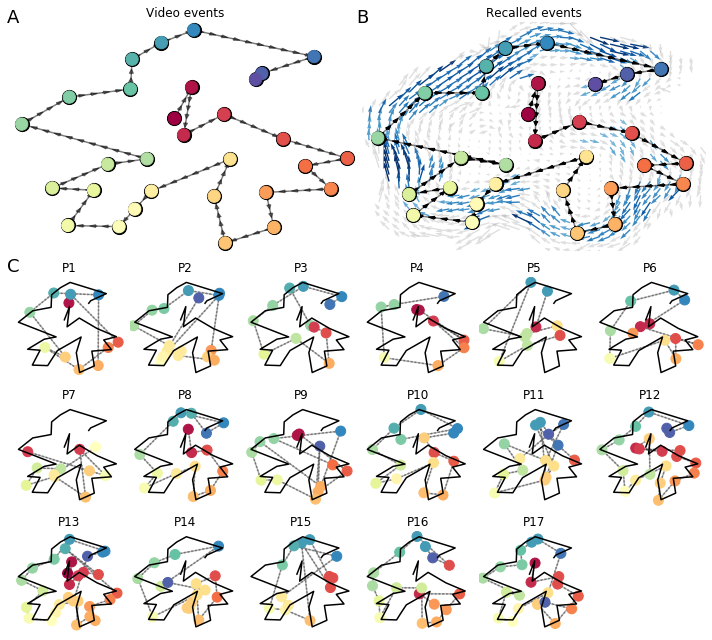

In [16]:
plt.figure(figsize=(10, 9))
axarr = [0, 0]
axarr[0] = plt.subplot2grid((5, 6), (0, 0), colspan=3, rowspan=2)
axarr[1] = plt.subplot2grid((5, 6), (0, 3), colspan=3, rowspan=2)
for i in range(2, 5):
    for j in range(0, 6):
        axarr.append(plt.subplot2grid((5, 6), (i, j)))

# ===== PANEL A =====
axarr[0].scatter(video_embedding[:, 0], 
                 video_embedding[:, 1], 
                 c=range(video_embedding.shape[0]), 
                 cmap=cmap, 
                 s=150, 
                 zorder=3)
axarr[0].scatter(video_embedding[:, 0], 
                 video_embedding[:, 1], 
                 c='k', 
                 cmap=cmap, 
                 s=200, 
                 zorder=2)
axarr[0].plot(video_embedding[:, 0], 
              video_embedding[:, 1], 
              zorder=1, 
              c='k', 
              alpha=.5)
add_arrows(axarr[0], 
           video_embedding[:, 0], 
           video_embedding[:, 1], 
           zorder=0, 
           alpha=.5, 
           color='k', 
           fill=True)
axarr[0].axis('off')
axarr[0].set_title('Video events')
axarr[0].set_xlim(-20, 21)
axarr[0].set_ylim(-17, 23)
axarr[0].text(0, 1, 'A',
              horizontalalignment='center',
              transform=axarr[0].transAxes,
              fontsize=18)

# ===== PANEL B =====
axarr[1].quiver(X, Y, U, V, 
                color=M.reshape(M.shape[0] * M.shape[1], 4), 
                zorder=1, 
                width=.004)
axarr[1].plot(avg_recall[:, 0], avg_recall[:, 1], zorder=2, c='k', alpha=.5)
add_arrows(axarr[1], 
           avg_recall[:, 0], 
           avg_recall[:, 1], 
           zorder=3, 
           alpha=1, 
           color='k', 
           fill=True)
axarr[1].scatter(avg_recall[:, 0], 
                 avg_recall[:, 1], 
                 c=range(avg_recall.shape[0]), 
                 cmap=cmap, 
                 s=150, 
                 zorder=4)
axarr[1].scatter(avg_recall[:, 0], 
                 avg_recall[:, 1], 
                 c='k', 
                 cmap=cmap, 
                 s=200, 
                 zorder=3)
axarr[1].axis('off')
axarr[1].set_title('Recalled events')
axarr[1].set_xlim(-20, 21)
axarr[1].set_ylim(-17, 23)
axarr[1].text(0, 1, 'B',
              horizontalalignment='center',
              transform=axarr[1].transAxes,
              fontsize=18)

# ===== PANEL C =====
for i, (e, m) in enumerate(zip(recall_embeddings, mappings)):
    ax = axarr[i + 2]
    ax.scatter(e[:, 0],
               e[:, 1], 
               c=cmap(m / video_embedding.shape[0]), 
               cmap=cmap, 
               s=100, 
               zorder=2)
    ax.plot(e[:, 0], e[:, 1], zorder=1, c='k', alpha=.25)
    add_arrows(ax, e[:, 0], e[:, 1], zorder=1, alpha=.25, color='k', fill=True)
    ax.plot(video_embedding[:, 0], video_embedding[:, 1], c='k', zorder=3)
    ax.axis('off')
    ax.set_xlim(-21, 23)
    ax.set_ylim(-18, 24)
    ax.set_title(f'P{i + 1}')

axarr[-1].axis('off')
axarr[2].text(0, 1.05, 'C',
              horizontalalignment='center',
              transform=axarr[2].transAxes,
              fontsize=18)

plt.tight_layout()
plt.subplots_adjust(wspace=.05, hspace=.25)
# plt.savefig(FIG_DIR.joinpath('trajectory.pdf'))
plt.show()